# Data Inspections Demo

In [1]:
import csv
import os
import sys
import re
import string
import json
import xml.etree.ElementTree as ET
from IPython.display import Image
import random
import numpy as np
import glob
import shutil
from termcolor import colored


from IPython.display import HTML as html_print
from IPython.display import Markdown

from transformers import AutoTokenizer

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

import cv2
import pandas as pd
from textwrap import wrap

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%pylab inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Some Useful Functions

In [2]:
def show_image_with_path(img_path, title=None, title_max_len=None, img_size=6):
    img = cv2.imread(img_path)
    # print(img.shape)
    plt.figure(figsize=(img_size, img_size))
    plt.imshow(img[:, :, ::-1])
    plt.axis('off')
    if title is not None:
        if title_max_len is not None:
            title = title[:title_max_len] + "... ..."
        title = "\n".join(wrap(title, 60))
        plt.title(title)
    pass ####


def show_one_sampled_data(data, scrambled=False, resized_version=False, 
                          show_label=False, unimodal=None, img_size=6,
                          title_max_len=None, show_url=False, id_mappings=None,
                          step_id=None, order=None):
    if step_id is not None:
        step_id -= 1

    if unimodal is not None:
        assert unimodal in ["image", "text"]
    
    text_seq = data.text_seq[:]
    img_path_seq = data.img_path_seq[:]
    idx_seq = np.arange(len(text_seq))
    
    if show_url:
        data_guid = data.guid
        if len(data_guid.split("###")) > 1:
            url, title = data_guid.split("###")[0], data_guid.split("###")[1]
        else:
            url = data_guid
        print(url)
    
    if scrambled:
        np.random.shuffle(idx_seq)
        # text_seq = [text_seq[x] for x in idx_seq]
        # img_path_seq = [img_path_seq[x] for x in idx_seq]
        idx_seq_to_sort = idx_seq[:]
        arg_sort_idx_seq = np.argsort(idx_seq_to_sort)
        label = list(arg_sort_idx_seq + 1)
        if show_label:
            print("Label: {}".format(arg_sort_idx_seq + 1))

    if order is not None:
        order = [x-min(order) for x in order]
        idx_seq = order
            
    for seq_idx in idx_seq:
        if step_id is not None:
            if seq_idx != step_id:
                continue
        if show_label:
            seq_idx_in_title = str(seq_idx + 1) + ". "
        else:
            seq_idx_in_title = ""
        text = text_seq[seq_idx]
        text = seq_idx_in_title + text
        img_path = img_path_seq[seq_idx]
        if not resized_version:
            img_path = img_path.replace("jpg_resized_256", "jpg")
        if unimodal == "image":
            show_image_with_path(img_path, title=None,
                                 title_max_len=title_max_len,
                                 img_size=img_size)
        elif unimodal == "text":
            img = cv2.imread(img_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(np.zeros(img.shape))
            plt.axis('off')
            title = "\n".join(wrap(text, 60))
            plt.title(title)
        else:
            show_image_with_path(img_path, title=text,
                                 title_max_len=title_max_len,
                                 img_size=img_size)
    
    if scrambled:
        return label
    
    return list(range(len(text_seq)))

## WikiHow Data Demo

### Read In WikiHow Data

In [3]:
from datasets.wikihow import WikiHowGeneralProcessor

version_text_to_use = "acl22"

wikihow_processor = WikiHowGeneralProcessor(version_text=version_text_to_use)
data_wikihow_train = wikihow_processor.get_train_examples()
data_wikihow_dev = wikihow_processor.get_dev_examples()
data_wikihow_test = wikihow_processor.get_test_examples()
data_wikihow = data_wikihow_train + data_wikihow_dev + data_wikihow_test

print("Total Valid Data Sequences: {}".format(len(data_wikihow)))

Using /local1/telinwu/research/multimodal_2020/sort/data_with_images/wikihow/wikihow-acl22-train.json


100%|██████████| 98270/98270 [00:21<00:00, 4532.16it/s]


[WARNING] Number of missing images in train: 76
          Saves at: data/wikihow/missing_images_train.txt
There are 134754 valid story sequences in /local1/telinwu/research/multimodal_2020/sort/data_with_images/wikihow/wikihow-acl22-train.json
Using /local1/telinwu/research/multimodal_2020/sort/data_with_images/wikihow/wikihow-acl22-dev.json


100%|██████████| 5459/5459 [00:00<00:00, 5546.51it/s]


[WARNING] Number of missing images in dev: 5
          Saves at: data/wikihow/missing_images_dev.txt
There are 6846 valid story sequences in /local1/telinwu/research/multimodal_2020/sort/data_with_images/wikihow/wikihow-acl22-dev.json
Using /local1/telinwu/research/multimodal_2020/sort/data_with_images/wikihow/wikihow-acl22-test.json


100%|██████████| 5757/5757 [00:01<00:00, 5504.88it/s]


[WARNING] Number of missing images in test: 1
          Saves at: data/wikihow/missing_images_test.txt
There are 7468 valid story sequences in /local1/telinwu/research/multimodal_2020/sort/data_with_images/wikihow/wikihow-acl22-test.json
Total Valid Data Sequences: 149068


### WikiHow Category Information (Can Skip)

In [5]:
categories_to_exclude = [                                                      
    "Youth",                                                                   
    "Relationships",                                                           
    "Family Life",                                                             
    "Holidays and Traditions",                                                 
    "Personal Care and Style",                                                 
    "Philosophy and Religion",                                                 
    "Screenplays",                                                             
    "Health",                                                                  
    "Work World",                                                              
    "Root",                                                                    
]

# URL to data mappings
def get_url_data_mappings(data):
    url_mappings = {}
    for i in range(len(data)):
        datum = data[i]
        url = datum.guid.split("###")[0]
        url_mappings[url] = i
    return url_mappings

# Obtaining url mappings
url_data_mappings = get_url_data_mappings(data_wikihow)

# Get category mappings
def read_in_wikihow_categories(url_data_mappings, cat_path=None, cat_level=1):
    if cat_path is None:
        json_f = "data/wikihow/wikihow-categories-output.json"
    else:
        json_f = cat_path
    json_in = open(json_f, "r")
    url2cat = {}
    cat2url = {}
    for line in json_in:
        cat = json.loads(line.strip())
        url = cat["url"]
        categories = cat["categories"]
        if url not in url_data_mappings:
            pass
        if len(categories) - 1 >= cat_level:
            cat_level_desc = categories[cat_level]["category title"]
        else:
            cat_level_desc = "Root"
        url2cat[url] = cat_level_desc
        if cat_level_desc not in cat2url:
            cat2url[cat_level_desc] = []
        cat2url[cat_level_desc].append(url)
    return url2cat, cat2url

cat_level = 1
url2cat, cat2url = read_in_wikihow_categories(url_data_mappings, cat_level=cat_level)
total = 0
for cat in sorted(cat2url):
    total += len(cat2url[cat])
    print("Category: {}  Num of Data: {}".format(cat, len(cat2url[cat])))
print("Number of categories: {}".format(len(cat2url)))

Category: Arts and Entertainment  Num of Data: 4675
Category: Cars & Other Vehicles  Num of Data: 2044
Category: Cleaning Heater Appliances  Num of Data: 1
Category: Computers and Electronics  Num of Data: 15023
Category: Education and Communications  Num of Data: 7406
Category: Family Life  Num of Data: 1747
Category: Finance and Business  Num of Data: 6228
Category: Food and Entertaining  Num of Data: 7670
Category: Google Play Music  Num of Data: 9
Category: Health  Num of Data: 8800
Category: Hobbies and Crafts  Num of Data: 9217
Category: Holidays and Traditions  Num of Data: 736
Category: Home and Garden  Num of Data: 9460
Category: Outdoor Shelters  Num of Data: 9
Category: Personal Care and Style  Num of Data: 6523
Category: Pets and Animals  Num of Data: 5281
Category: Philosophy and Religion  Num of Data: 828
Category: Relationships  Num of Data: 2877
Category: Root  Num of Data: 432
Category: Screenplays  Num of Data: 2
Category: Sports and Fitness  Num of Data: 3271
Categor

### Show One Sample

https://www.wikihow.com/Make-Your-Own-Pseudonym


[0, 1, 2, 3, 4]

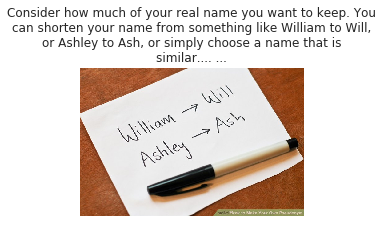

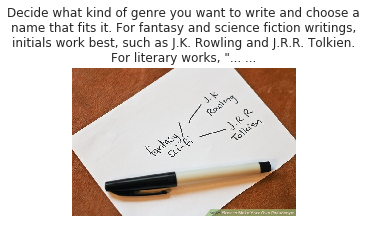

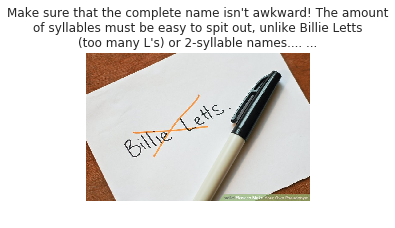

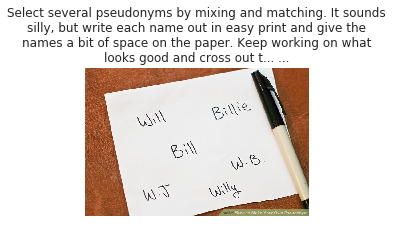

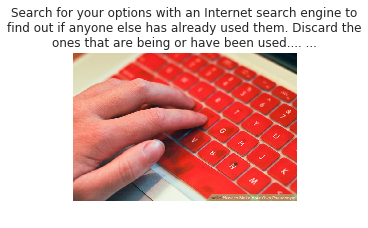

In [6]:
rand_idx = np.random.randint(len(data_wikihow))

show_one_sampled_data(data_wikihow[rand_idx], 
                      scrambled=False,
                      title_max_len=200,
                      show_url=True,
                      img_size=4)

# RecipeQA  Data Demo

### Read In WikiHow Data

In [7]:
from datasets.recipeqa import RecipeQAGeneralProcessor

version_text_to_use = "acl22"

recipeqa_processor = RecipeQAGeneralProcessor(version_text=version_text_to_use)
data_recipeqa_train = recipeqa_processor.get_train_examples()
data_recipeqa_dev = recipeqa_processor.get_dev_examples()
data_recipeqa_test = recipeqa_processor.get_test_examples()
data_recipeqa = data_recipeqa_train + data_recipeqa_dev + data_recipeqa_test

print("Total Valid Data Sequences: {}".format(len(data_recipeqa)))

Using /local1/telinwu/research/multimodal_2020/sort/data_with_images/recipeQA/new_splits/train-acl22.json


100%|██████████| 29256/29256 [00:00<00:00, 373396.54it/s]


There are 5336 valid story sequences in /local1/telinwu/research/multimodal_2020/sort/data_with_images/recipeQA/new_splits/train-acl22.json
Using /local1/telinwu/research/multimodal_2020/sort/data_with_images/recipeQA/new_splits/val-acl22.json


100%|██████████| 3513/3513 [00:00<00:00, 337477.15it/s]


There are 662 valid story sequences in /local1/telinwu/research/multimodal_2020/sort/data_with_images/recipeQA/new_splits/val-acl22.json
Using /local1/telinwu/research/multimodal_2020/sort/data_with_images/recipeQA/new_splits/test-acl22.json


100%|██████████| 4017/4017 [00:00<00:00, 356514.51it/s]

There are 772 valid story sequences in /local1/telinwu/research/multimodal_2020/sort/data_with_images/recipeQA/new_splits/test-acl22.json
Total Valid Data Sequences: 6770


### Show One Sample

quick-n-spicy-potato-fries


[0, 1, 2, 3, 4]

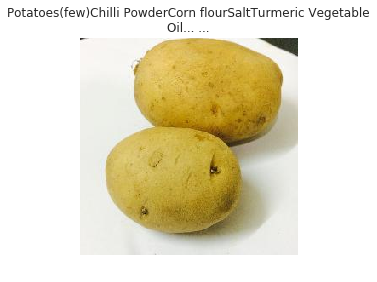

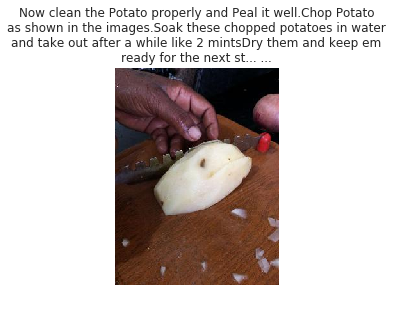

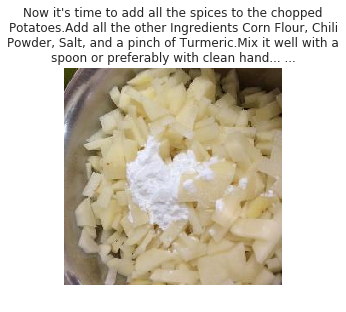

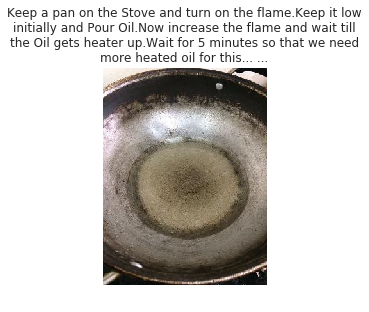

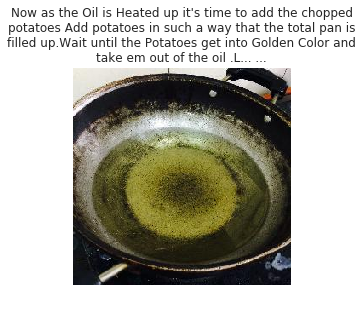

In [8]:
rand_idx = np.random.randint(0, len(data_recipeqa))

show_one_sampled_data(data_recipeqa[rand_idx], 
                      scrambled=False,
                      title_max_len=200,
                      show_url=True,
                      img_size=4)

## End